<a href="https://colab.research.google.com/github/guilhermecarva/guilhermecarva/blob/main/Deteccao_objetos_Visao_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
import zipfile
import pandas as pd

Vamos extrair as imagens dos arquivo zip de treino e teste

In [ ]:
train_path = "/content/drive/MyDrive/Mentorama/test1.zip"
test_path = "/content/drive/MyDrive/Mentorama/train.zip"

files = "/kaggle/working/"

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

Agora podemos criar um DataFrame com o nome dos arquivos e aproveitamos parte do nome para criar um label para cada arquivo

In [ ]:
image_dir = "../kaggle/working/train"

filenames = os.listdir(image_dir)

labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})
data.head()

,filename,label
0,dog.2374.jpg,dog
1,cat.8319.jpg,cat
2,dog.9346.jpg,dog
3,dog.7101.jpg,dog
4,cat.7830.jpg,cat


In [ ]:
pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4335 sha256=affd9b702a1d66e4243b69049c67605ef6d7f7b24c3c5037ac2fc8b55038e7ea
  Stored in directory: /root/.cache/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch


Para melhor didática vamos utilizar o Selective Search primeiro em uma única imagem aleatória.

In [ ]:
import selectivesearch

In [ ]:
image = cv2.imread('../kaggle/working/train/cat.6256.jpg')

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

In [ ]:
ss.switchToSelectiveSearchFast()

In [ ]:
retangulos = ss.process()

In [ ]:
retangulos.shape

(800, 4)

Agora que possuímos os bounding boxes, vamos plotar uma imagem com os mesmos

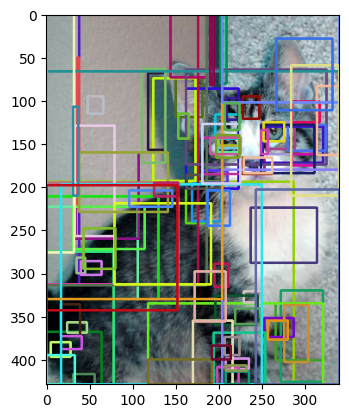

In [ ]:
output = image.copy()
for (a, b, w, h) in retangulos[0:100,]:
		color = [np.random.randint(0, 255) for j in range(0, 3)]
		cv2.rectangle(output, (a, b), (a + w, b + h), color, 2)

plt.imshow(output)

Como limitamos a quantidade de boxes em 100, para este tipo de imagem com poucos objetos me parece um certo exagero. Pois temos muitos boxes pequenos sem importância.

Vamos plotar apenas um box

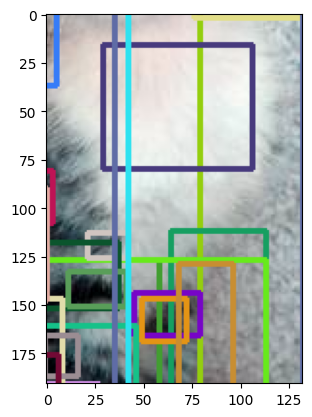

In [ ]:
plt.imshow(output[retangulos[2][0]:retangulos[2][1],retangulos[2][0]:retangulos[2][1]])

Vamos plotar novamente apenas um box aleatório somente com a imagem.

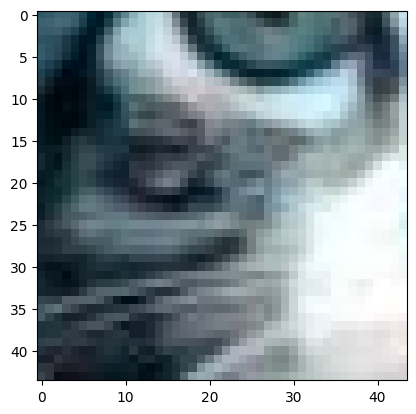

In [ ]:
ret = retangulos[np.random.randint(low = 0, high = retangulos.shape[0], size = 1),]
x, y, w, h = ret[0]
plt.imshow(image[y:y+h,x:x+w])

Podemos obter as coordenadas de 100 boxes aleatórios e criar uma lista.

In [ ]:
retangulos_aleatorios = retangulos[np.random.randint(low = 0, high = retangulos.shape[0], size = 100),]
boxes = []
for x, y, w, h in retangulos_aleatorios:
  boxes.append(image[y:y+h,x:x+w])

In [ ]:
print(len(boxes))

100


Agora que vimos e entendemos o passo a passo, vamos criar uma função que recebe uma imagem e a quantidade de bounding boxes, aplica o selective search e nos retorna uma lista com as bounding boxes.

In [ ]:
def subimagem(img_escolhida,k):
  boxes=[]
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.clearGraphSegmentations()
  ss.clearImages()
  ss.clearStrategies()
  image = cv2.imread(img_escolhida)
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  retangulos = ss.process()
  retangulos_aleatorios = retangulos[np.random.randint(low = 0, high = retangulos.shape[0], size = k),]
  output = image.copy()

  for x, y, w, h in retangulos_aleatorios:
    if w>10 and h>10:
      try:
        color = [np.random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
        boxes.append(image[y:y+h,x:x+w])
      except:
        pass

  return boxes


In [ ]:
# fazendo um teste da função com apenas 1 imagem
boxes = subimagem(os.path.join(image_dir,data['filename'].iloc[90]),100)

In [ ]:
len(boxes)

95

Mesmo utilizando em nossa função k = 100, temos apenas 95 áreas de interesse, pois limitando seu tamanho.

Para treinar nosso modelo vamos dividir nosso dataset de treino em: treino, teste e validação. Depois vamos classificar as imagens da nossa função que acabamos de criar.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
labels = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 23)

label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 23)

In [ ]:
print(X_train.shape, X_test.shape, X_val.shape)

(20000, 2) (2500, 2) (2500, 2)


Vamos criar um Data Set com os path´s e nomes das imagens de treino.

In [ ]:
set_train = []
i = 0
while i < len(X_train):
  set_train.append(os.path.join(image_dir,X_train['filename'].iloc[i]))
  i = i+1

In [ ]:
len(set_train)

20000

In [ ]:
#selecionando uma imagem aleatória para utlizarmos
imagem = set_train[np.random.randint(low = 0, high = len(set_train), size = 1)[0]]
print(imagem)

../kaggle/working/train/dog.12423.jpg


Esta será a imageM que iremos utilizar no classificador.<br>
Aplicando nossa função na imagem escolhida

In [ ]:
boxes = subimagem(imagem,100)

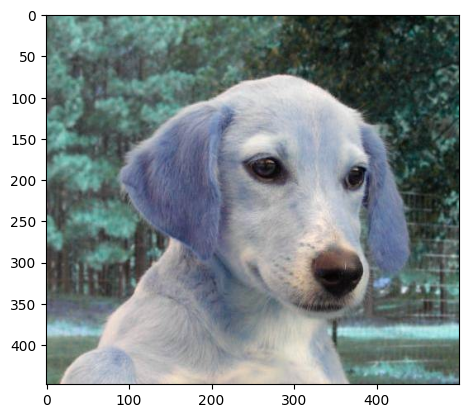

In [ ]:
plt.imshow(cv2.imread(imagem))

In [ ]:
len(boxes)

96

Vamos verificar qual a média do tamanho de nossas imagens do dataset de treino.

In [ ]:
image_width = []
image_height = []
x=0
while x < len(data['filename']):
    image = cv2.imread(os.path.join(image_dir,data['filename'][x]))
    height, width, _ = image.shape
    image_width.append(width)
    image_height.append(height)
    x = x+1
    #print(height, width)

median_width = np.median(image_width)
median_height = np.median(image_height)


print('median_size:', median_width,  'X', median_height)

median_size: 447.0 X 374.0


Os modelos de CNN podem processar imagens quadradas, então iremos utilizar imagens de 370 X 370

Vamos importar as bibliotecas para aplicar o aprendizado do modelo VGG19

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

#importando a aplicação vgg19 do imagenet. Como o include_top será False, devemos especificar o input_shape
from keras.applications.vgg19 import VGG19

Vamos criar o gerador de imagens "normalizando" o tamanho das imagens

Para os datasets de validação e teste utilizaremos shuffle = false, ou seja, as imagens terão a mesma ordem em que aparecem no dataframe

In [ ]:
batch_size = 64
size = (370, 370)
gerador = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg19.preprocess_input)

In [ ]:
train_g = gerador.flow_from_dataframe(X_train, image_dir, x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=size)

val_g = gerador.flow_from_dataframe(X_val, image_dir, x_col="filename", y_col="label",
                                  batch_size = batch_size,
                                  target_size = size, shuffle = False)

test_g = gerador.flow_from_dataframe(X_test, image_dir, x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=size, shuffle = False)

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
eff_model = VGG19(weights='imagenet', include_top = False, input_shape=(370, 370, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
#vamos instanciar o modelo apenas para poder alterar os parâmetros treináveis
model2 = keras.Sequential()
for layer in eff_model.layers:
    model2.add(layer)

In [ ]:
for layer in model2.layers:
    layer.trainable = False

In [ ]:
# Adicionando layers no final.
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 370, 370, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 370, 370, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 185, 185, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 185, 185, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 185, 185, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 92, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 92, 92, 256)       2

In [ ]:
model2.output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_1')>

In [ ]:
#Compilando o modelo
model2.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics = ["acc"])

In [ ]:
#Criando callback
model_ckpt = tf.keras.callbacks.ModelCheckpoint("DogCat",
                                                monitor="val_loss",
                                                save_best_only=True)

O callback irá salvar o melhor modelo durante o treinamento baseado na 'validation loss' <br> O modelo salvo terá o prefixo 'DogCat'

In [ ]:
history = model2.fit(train_g, batch_size=batch_size, validation_data=val_g, epochs = 8, callbacks=[model_ckpt])

Epoch 1/8
313/313 [==============================] - 362s 1s/step - loss: 1.2181 - acc: 0.9636 - val_loss: 0.0480 - val_acc: 0.9828
Epoch 2/8
313/313 [==============================] - 323s 1s/step - loss: 0.0178 - acc: 0.9923 - val_loss: 0.0567 - val_acc: 0.9828
Epoch 3/8
313/313 [==============================] - 323s 1s/step - loss: 0.0059 - acc: 0.9976 - val_loss: 0.0910 - val_acc: 0.9780
Epoch 4/8
313/313 [==============================] - 322s 1s/step - loss: 0.0028 - acc: 0.9987 - val_loss: 0.0714 - val_acc: 0.9820
Epoch 5/8
313/313 [==============================] - 323s 1s/step - loss: 0.0107 - acc: 0.9974 - val_loss: 0.0753 - val_acc: 0.9836
Epoch 6/8
313/313 [==============================] - 323s 1s/step - loss: 0.0121 - acc: 0.9956 - val_loss: 0.0850 - val_acc: 0.9828
Epoch 7/8
313/313 [==============================] - 327s 1s/step - loss: 0.0054 - acc: 0.9978 - val_loss: 0.0780 - val_acc: 0.9836
Epoch 8/8
313/313 [==============================] - 323s 1s/step - loss: 0.

Vamos verificar a acurácia de nosso modelo, carregando o "melhor" modelo que acabamos de salvar.

In [ ]:
cat_dog_model = tf.keras.models.load_model("DogCat")
result = cat_dog_model.predict(test_g)
result_argmax = np.argmax(result, axis=1)

y_true = test_g.labels
y_pred = result_argmax

accuracy = (y_pred == y_true).mean()

print("Acurácia:", accuracy)

40/40 [==============================] - 37s 946ms/step
Acurácia: 0.9796


Com o nosso subset que pegamos do dataset de treino obtivemos uma acurácia de 98%

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1250
           1       0.99      0.97      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



Como podemos observar, as duas classes ( 0 e 1 ) foram bem classificadas.

Agora vamos classificar nosso subset dos retângulos. Ou seja, das imagens obtidas pelas bounding boxes da imagem aleatória escolhida anteriormente.

Para tanto, teremos que alterar a porporção da nossa imagem. Os retângulos possuem tamanhos diversos. E assim como fizemos um preprocessing das imagens para utilizar no VGG19, teremos de alterar o tamanho das imagens ( boxes ) para a predição.

In [ ]:
boxes_resized=[]
x=0
while x < len(boxes):
  img=boxes[x]
  resize_width = 370
  resize_height = 370
  resized_dimensions = (resize_width, resize_height)
  resized=cv2.resize(img, resized_dimensions,interpolation=cv2.INTER_AREA)
  boxes_resized.append(resized)
  x=x+1


In [ ]:
#criando um array da lista das boxes resized
boxes_resized_arr=np.array(boxes_resized)

In [ ]:
boxes_resized_arr.shape

(96, 370, 370, 3)

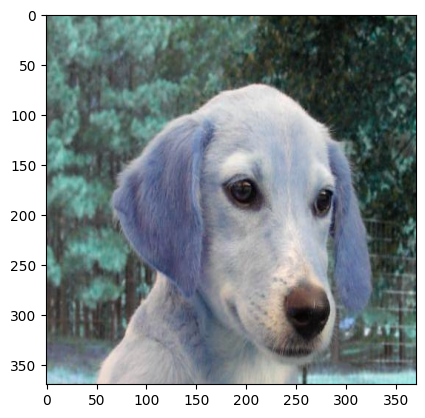

In [ ]:
#plot aleatório para vermos como ficou a imagem
plt.imshow(boxes_resized_arr[3])

In [ ]:
#predizendo as nossas imagens
boxes_predict = cat_dog_model.predict(boxes_resized_arr)

boxes_predict_argmax = np.argmax(boxes_predict, axis=1)

y_test_pred = boxes_predict_argmax

3/3 [==============================] - 1s 400ms/step


In [ ]:
train_g.class_indices

{'cat': 0, 'dog': 1}

Temos duas classes:<br>0 = CAT<br>1 = DOG<br>

In [ ]:
print(y_test_pred) #nosso array predito

[0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Vamos verificar como a imagem escolhida é classificada pelo nosso modelo. <br> Para tanto, vamos contar qual classe obteve maior ocorrência em nosso array de predição.

In [ ]:
cat = np.unique(y_test_pred, return_counts=True)[1][0]
dog = np.unique(y_test_pred, return_counts=True)[1][1]
if cat>dog:
  print('SUA IMAGEM É UM GATO')
elif cat==dog:
  print('ESTOU EM DÚVIDA SE É UM GATO OU UM CACHORRO')
elif cat<dog:
  print('SUA IMAGEM É UM CACHORRO')

SUA IMAGEM É UM GATO


# Como podemos verificar nosso classificador apesar de uma excelente acurácia, não foi capaz de classificar corretamente nosso subset. Isto porque poucas imagens realmente parecem um cachorro.

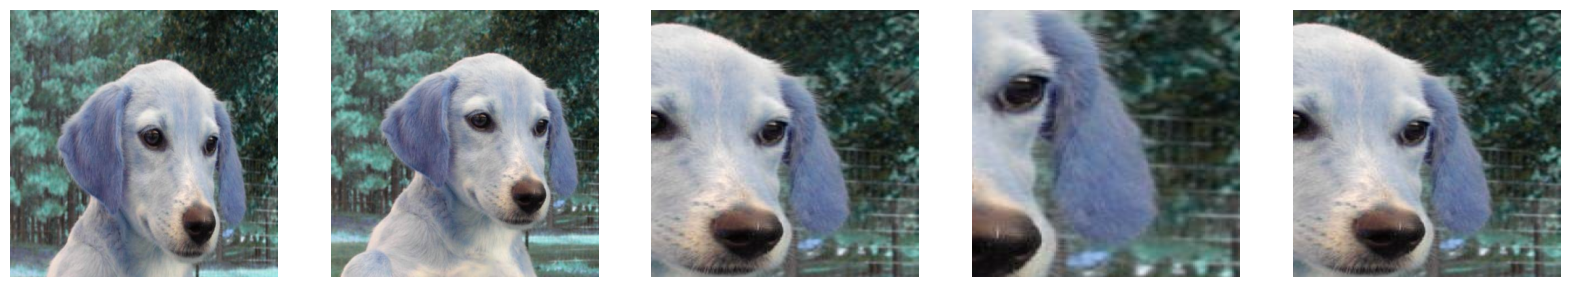

In [ ]:
um = np.where(y_test_pred == 1)[0]
rge = len(um)

fig, axes = plt.subplots(1, rge, figsize=(20, 4))
for idx in range(rge):
    image = boxes_resized_arr[um[idx]]
    axes[idx].imshow(image)
    axes[idx].axis('off')
plt.show()

Apenas estas imagens remetem a um cachorro. É bem provável que as demais mostram cortes do fundo e/ou partes brancas apenas.